In [1]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the dataset from a CSV file
input_file = '/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv'  # Replace with your file path
df = pd.read_csv(input_file)

# Define how many rows you want to process (e.g., 5000 rows)
num_rows_to_process = 5  # Change this number as needed

# Use the first N rows
df_subset = df.head(num_rows_to_process)

# Load a pre-trained GPT-2 model and tokenizer
model_name = 'gpt2-medium'  # You can change this to another model if needed
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Function to generate meaningful text using a generative model
def generate_text_with_model(transaction_info):
    # Create a customized prompt for each transaction
    prompt = (
        f"The customer performed a {transaction_info['type']} transaction "
        f"with an amount of {transaction_info['amount']}. "
        f"The customer's initial balance was {transaction_info['oldbalanceOrg']} "
        f"and after the transaction, it became {transaction_info['newbalanceOrig']}. "
        f"The recipient had an initial balance of {transaction_info['oldbalanceDest']} "
        f"and after the transaction, it increased to {transaction_info['newbalanceDest']}. "
        
    )

    # Encode input prompt and generate output
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=150,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.8  # Slightly lower temperature to keep the output meaningful but varied
        )
    
    # Decode the generated text and return
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # You can further post-process the generated text to improve readability if needed
    return generated_text

# Generate textual representations and labels
df_subset['Textual Representation'] = df_subset.apply(generate_text_with_model, axis=1)
df_subset['Label'] = df_subset['isFraud'].apply(lambda x: "Fraudulent" if x == 1 else "Non-Fraudulent")

# Save the new dataframe with textual representations and labels to a new Excel file
output_file = 'fraud_sentiment_analysis_with_labels.xlsx'
df_subset[['Textual Representation', 'Label']].to_excel(output_file, index=False)

#print(f"Textual representation with labels for {num_rows_to_process} rows has been saved to {output_file}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Load the new dataset
output_file = '/kaggle/input/final-excel/fraud_sentiment_analysis_with_labels (5).xlsx'
df = pd.read_excel(output_file)

# Text and labels
texts = df['Textual Representation'].values
labels = df['Label'].values

# Encode labels as integers
label_to_int = {'Non-Fraudulent': 0, 'Fraudulent': 1}
labels_encoded = np.array([label_to_int[label] for label in labels])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels_encoded, test_size=0.2, random_state=42)

# Tokenize the text data
max_words = 10000  # Maximum number of unique words
max_sequence_length = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense

# Define the model
model = Sequential()

# Add an Embedding layer
# input_dim = size of the vocabulary
# output_dim = size of the embedding vectors
# input_length = length of input sequences
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))

# Add a SimpleRNN layer
model.add(SimpleRNN(64))

# Add a Dropout layer
model.add(Dropout(0.5))

# Add a Dense output layer (e.g., for binary classification)
model.add(Dense(2, activation='softmax'))

# Manually build the model with input shape to avoid unbuilt model
model.build(input_shape=(None, 100))  # batch size is 'None', sequence length is 100
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test_cat))



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,386 (2.47 MB)

 Trainable params: 648,386 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9656 - loss: 0.0880 - val_accuracy: 0.9880 - val_loss: 0.0797
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9934 - loss: 0.0422 - val_accuracy: 0.9880 - val_loss: 0.0732
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9934 - loss: 0.0401 - val_accuracy: 0.9880 - val_loss: 0.0663
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9943 - loss: 0.0375 - val_accuracy: 0.9880 - val_loss: 0.0672
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9947 - loss: 0.0276 - val_accuracy: 0.9880 - val_loss: 0.0675
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9913 - loss: 0.0311 - val_accuracy: 0.9850 - val_loss: 0.0653
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9974 - loss: 0.0089 - val_accuracy: 0.9850 - val_loss: 0.0615
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9970 - loss: 0.0128 - val_accu

In [18]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Accuracy: {accuracy:.2f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - loss: 0.0469
Test Accuracy: 0.99


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


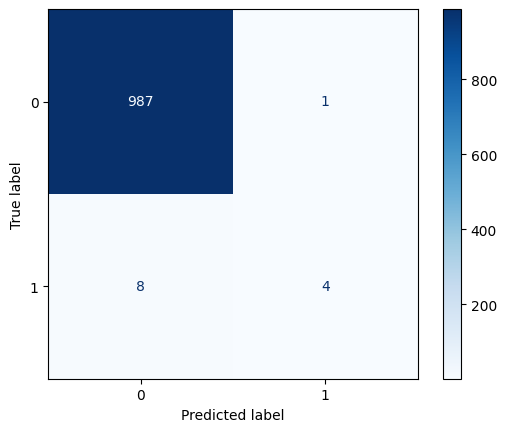

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming your test labels are in one-hot encoding, you can convert them back to class indices
y_test_true = np.argmax(y_test_cat, axis=1)

# Get model predictions on the test set
y_pred = model.predict(X_test_pad)

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.show()


In [23]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test_true, y_pred_classes, target_names=['Class 0', 'Class 1'])

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       988
     Class 1       0.80      0.33      0.47        12

    accuracy                           0.99      1000
   macro avg       0.90      0.67      0.73      1000
weighted avg       0.99      0.99      0.99      1000



In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Example text input to test
test_texts = ['''  The customer performed a PAYMENT transaction with an amount of 1864.28. 
The customer's initial balance was 21249.0 and after the transaction, it became 19384.72. 
The recipient had an initial balance of 0.0 and after the transaction, it increased to 0.0. ''']

# Tokenizer parameters should be the same as those used during training
# Assuming you already have a tokenizer used for training
# Example:
# tokenizer = Tokenizer(num_words=10000)

# Tokenize the new text
sequences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences to match the input length used in training (in this case, input_length=100)
test_texts_pad = pad_sequences(sequences, maxlen=100)

# Predict the class of the new text
predictions = model.predict(test_texts_pad)

# If you're working with a binary classification (2 classes, softmax), the predicted class is:
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted class back to a human-readable label (optional)
class_labels = {0: 'Class 0', 1: 'Class 1'}  # Modify as needed

# Print out predictions
for i, text in enumerate(test_texts):
    print(f"Text: {text}")
    print(f"Predicted Class: {class_labels[predicted_classes[i]]}")
    print(f"Prediction Confidence: {predictions[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Text:   The customer performed a PAYMENT transaction with an amount of 1864.28. 
The customer's initial balance was 21249.0 and after the transaction, it became 19384.72. 
The recipient had an initial balance of 0.0 and after the transaction, it increased to 0.0. 
Predicted Class: Class 0
Prediction Confidence: [9.999527e-01 4.733177e-05]
